## Прогноз Заработной Платы в России

In [43]:
import pandas as pd

import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import itertools

from scipy import stats

%pylab inline

def invboxcox(y,lmbda):
    if (lmbda == 0):
        return (np.exp(y))
    else:
        return (np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [44]:
sal = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
sal.columns = ['salary']
sal.head()

,salary
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


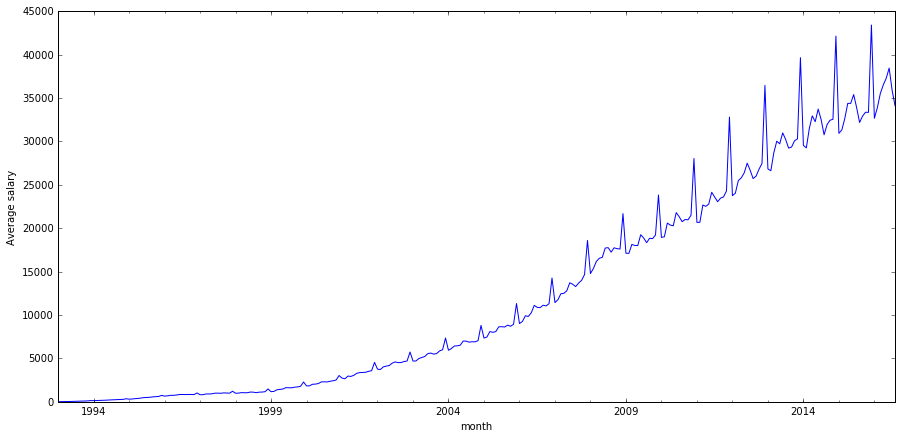

In [45]:
plt.figure(figsize(15,7))
sal['salary'].plot()
plt.ylabel('Average salary')
pylab.show()

Метод пристального взгляда показывает, что а) имеется явно выраженный тренд: зарплата растёт; б) начиная с конца 90-х начинает просматриваться сезонность; в) дисперсия не стационарна (увеличивается со временем).

Проверим критерием Дики-Фуллера формально стационарность:

In [46]:
print "Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(sal['salary'])[1]

Критерий Дики-Фуллера: p = 0.991850


Значение p-value достаточно большое, гипотеза нестационарности для этого ряда не отвергается.

Сделаем STL-декомпозицию:

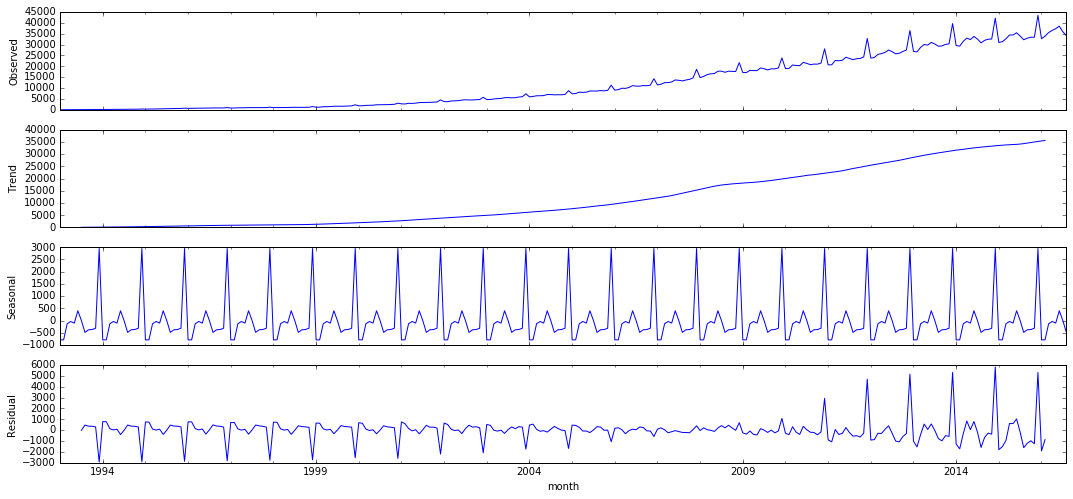

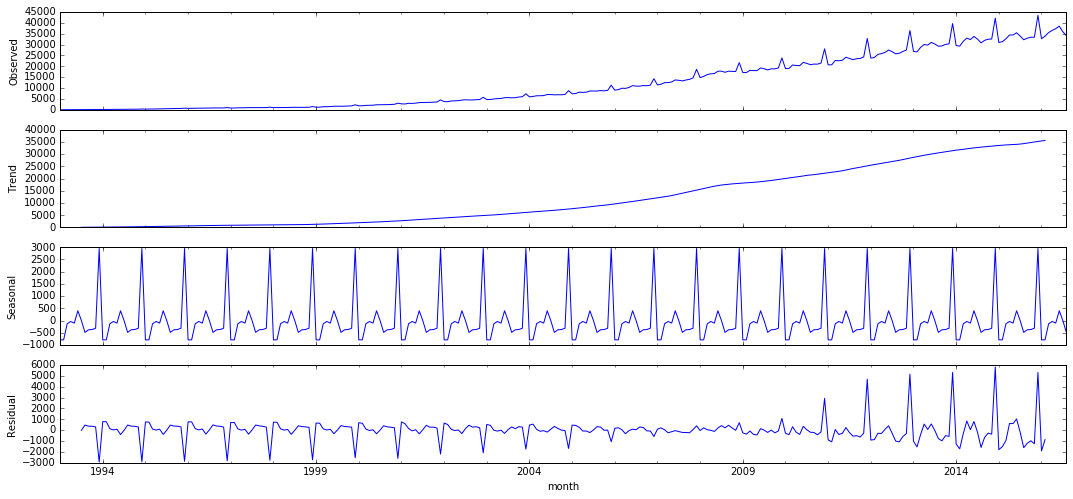

In [47]:
sm.tsa.seasonal_decompose(sal['salary']).plot()

Видим, что тренд имеет простую повышающуюся структуру. Сезонность - к бабке не ходи. Довольно интересная небанальная структура в ошибках.

Сделаем стабилизацию дисперсии методом Бокса-Кокса.

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


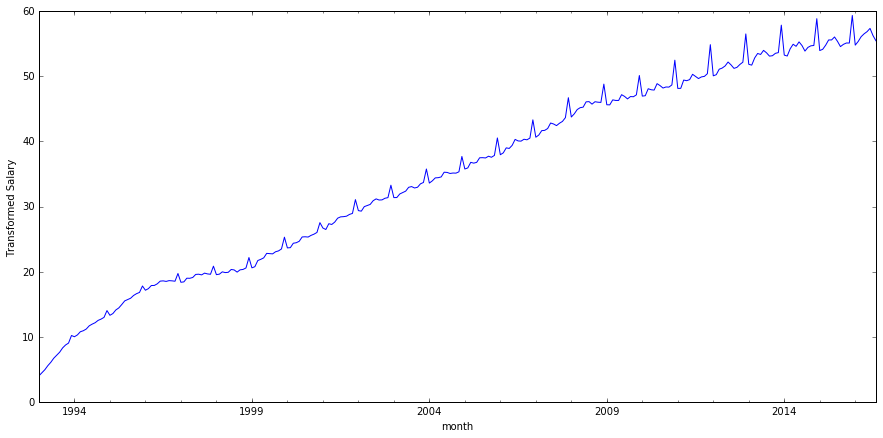

In [48]:
sal['salary_box'], lmbda = stats.boxcox(sal['salary'])

plt.figure(figsize(15,7))
sal['salary_box'].plot()
plt.ylabel(u'Transformed Salary')

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sal['salary_box'])[1])

Критерий Дики-Фуллера на этот раз даёт р-value поменьше, но всё еще слишком большую. Наш ряд всё еще не стационарен.

Будем дифференцировать наш ряд с целью добиться стационарности. Сначала сделаем сезонное дифференцирование:

Критерий Дики-Фуллера: p=0.014697


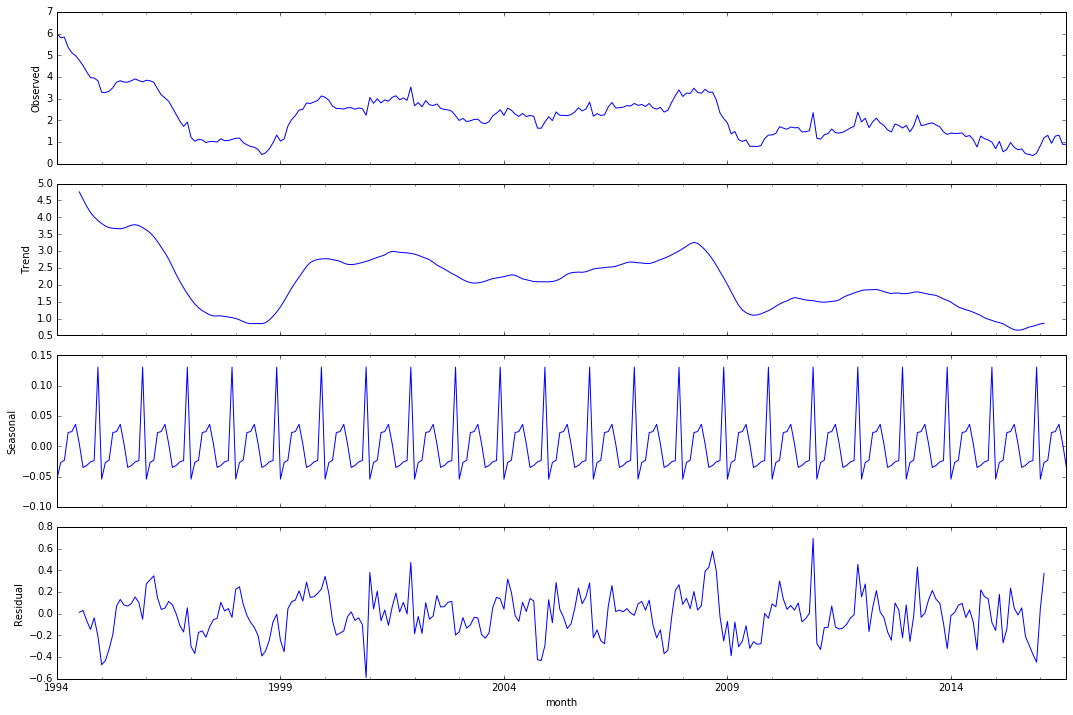

In [49]:
sal['sales_box_diff'] = sal['salary_box'] - sal['salary_box'].shift(12)

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(sal['sales_box_diff'][12:]).plot()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sal['sales_box_diff'][12:])[1])

На этот раз критерий Дики-Фуллера отвергает нулевую гипотезу (о нестационарности), но кажется, что еще есть некоторый понижающий тренд. Так как нас предупреждали о том, что критерий Д-Ф не особо надежен, то сделаем еще одно дифференцирование, обычное на этот раз:

Критерий Дики-Фуллера: p=0.000000


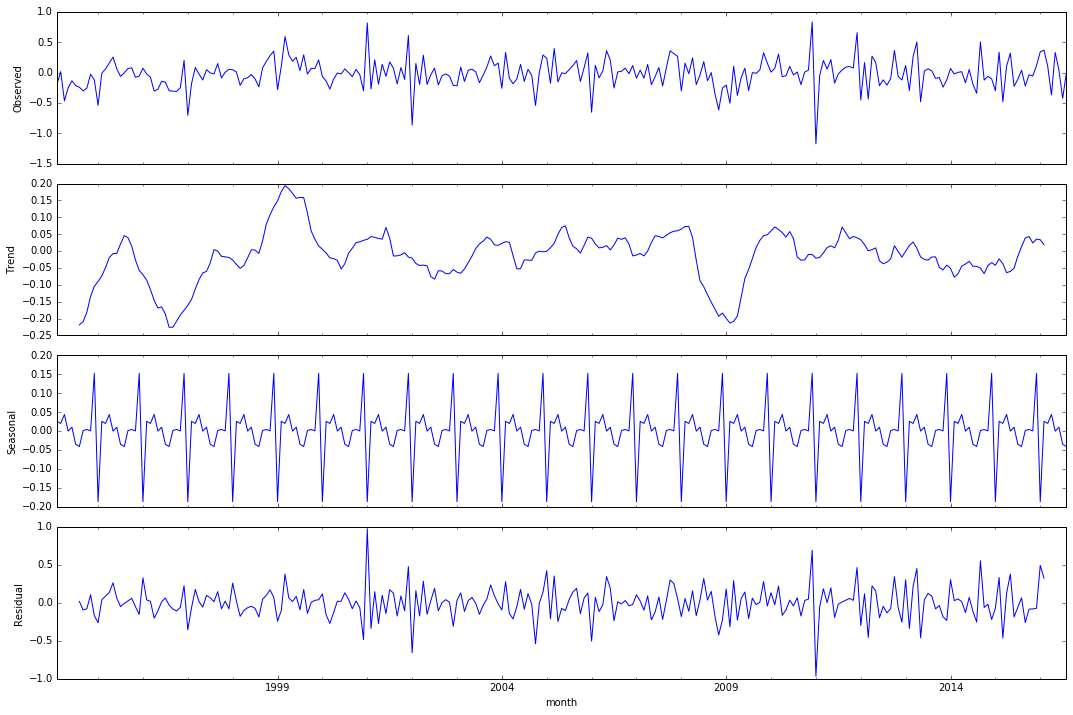

In [50]:
sal['sales_box_diff2'] = sal['sales_box_diff'] - sal['sales_box_diff'].shift(1)

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(sal['sales_box_diff2'][13:]).plot()   

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sal['sales_box_diff2'][13:])[1])

Теперь значение p-value совсем маленькое, т.е. мы очень уверенно отвергаем нулевую гипотезу о нестационарности. Похоже, нам удалось избавиться от тренда.

Переходим к выбору начальных приближений для p, q, P, Q.

Рисуем автокорреляционную и частично автокорреляционную функцию два раза продифференцированного ряда:

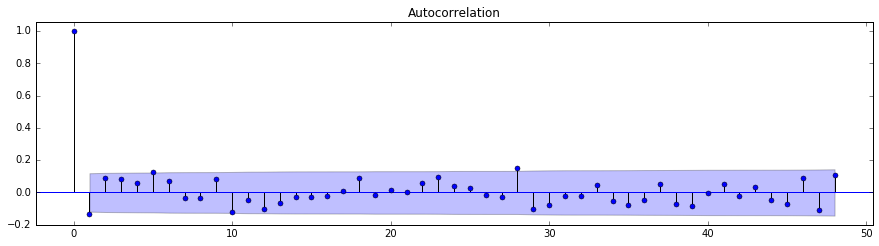

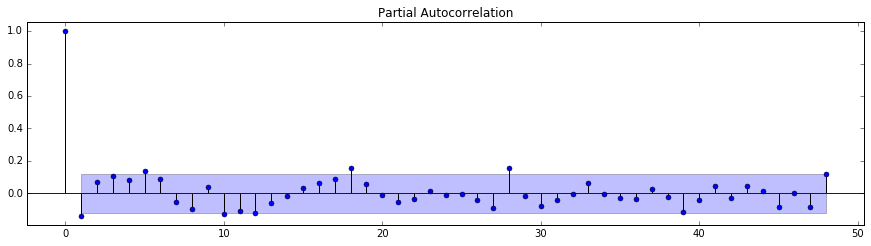

In [51]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(sal['sales_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(sal['sales_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Предлагается выбрать следующие начальные значения: Q=0, q=1, P=0, p=5.

Сделаем перебор возможных параметров:

In [52]:
ps = range(0, 8)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

96

In [53]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(sal['salary_box'], order=(param[0], d, param[1]), \
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 0, 1))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 1, 1))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 0, 1))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 1, 1))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 0, 1))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 2, 1, 1))
('wrong parameters:', (4, 2, 0, 0))
('wrong parameters:', (4, 2, 0, 1))
('wrong parameters:', (4, 2, 1, 0))
('wrong parameters:', (4, 2, 1, 1))
('wrong parameters:', (5, 2, 0, 0))
('wrong parameters:', (5, 2, 0, 1))
('wrong parameters:', (5, 2, 1, 0))
('wrong parameters:', (5, 2, 1, 1))
Wall time: 49.2 s


In [54]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
49  (6, 0, 1, 0) -7.552970
50  (6, 0, 1, 1) -7.213253
48  (6, 0, 0, 1) -6.591533
61  (7, 0, 1, 0) -5.553215
53  (6, 1, 1, 0) -5.553082


In [55]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(6, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  11.776
Date:                            Wed, 28 Dec 2016   AIC                             -7.553
Time:                                    08:24:51   BIC                             21.639
Sample:                                01-01-1993   HQIC                             4.151
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1991      0.045     -4.401      0.000      -0.288      -0.110
ar.L2          0.0224      0.066   

Видим значение статистики критерия Льюнг — Бокса при каком-то автоматически выбранном Q и соответствующий достигаемый уровень значимости. Достигаемый уровень значимости достаточно большой. То есть, по всей видимости, остатки модели не автокоррелированы.  

Сделаем визуальный анализ остатков нашей модели.

Критерий Стьюдента: p=0.293136
Критерий Дики-Фуллера: p=0.000000


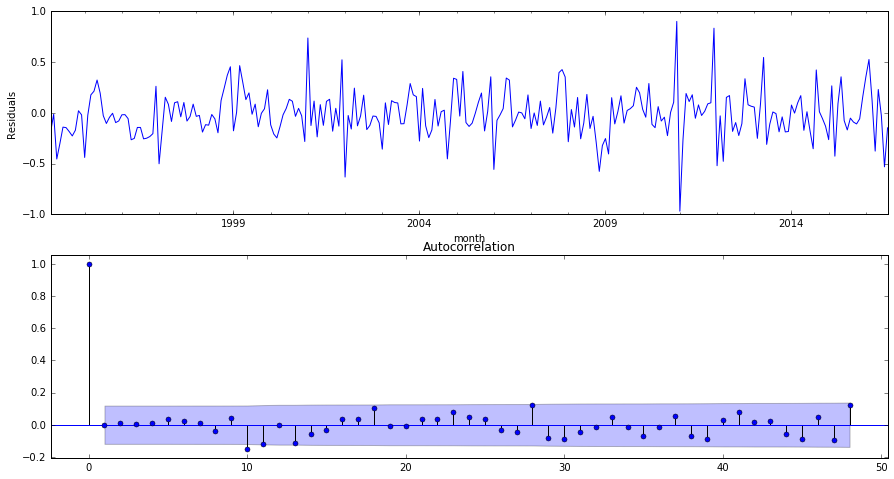

In [56]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Стьюдента проверяет гипотезу несмещённости и её не отвергает с достигаемым уровнем значимости примерно 0.29. Критерий Дики-Фуллера уверенно отвергает гипотезу нестационарности. Таким образом, мы получаем, что остатки не смещены, стационарны и неавтокоррелированы. Следовательно, модель достаточно хороша. 

Посмотрим, насколько хорошо эта модель описывает данные.

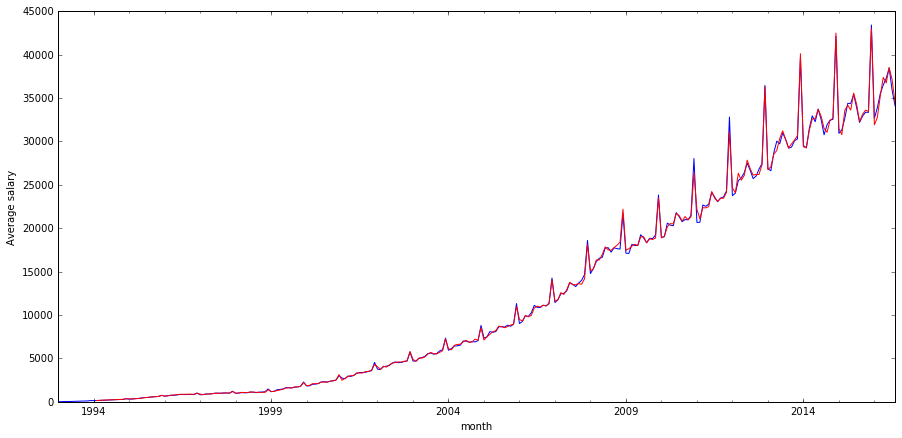

In [57]:
sal['model'] = invboxcox(best_model.fittedvalues, lmbda)

plt.figure(figsize(15,7))
sal['salary'].plot()
sal['model'][13:].plot(color='r')
plt.ylabel('Average salary')
pylab.show()

Недурно. Наконец, прогноз:

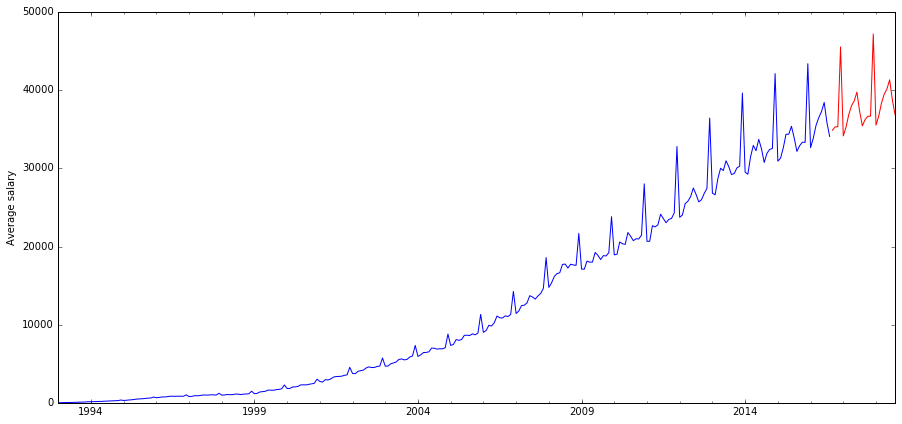

In [58]:
sal2 = sal[['salary']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= sal2.columns)
sal2 = pd.concat([sal2, future])
sal2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

plt.figure(figsize(15,7))
sal2['salary'].plot()
sal2['forecast'].plot(color='r')
plt.ylabel('Average salary')
pylab.show()